In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader 

from tqdm.notebook import tqdm as tqdm_nb
from torchvision.datasets import MNIST
import warnings
warnings.filterwarnings("ignore")

import io
import imageio
import numpy as np
from PIL import Image
from torchvision.transforms.transforms import Lambda
import torchvision.transforms as T

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, z_dim),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 64 * 7 * 7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 64, 3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Tanh(),
        )

        self.latent = torch.empty(z_dim)

    def forward(self, x):
        x = self.encoder(x)
        encoder = x
        self.latent = x.clone()
        x = self.decoder(x)
        return encoder, x

In [34]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

In [35]:
download_root = './'
train_dataset = MNIST(download_root, transform=transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=transform, train=False, download=True)

In [42]:
batch_size = 256 # batch size
z_dim = 98
Epochs = 20

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


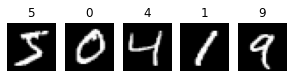

In [43]:
ds = train_dataset
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(5, 25))  # 5행 1열로 subplot 생성
for i in range(5):
    image, label = ds[i]
    axs[i].set_title(label)
    axs[i].imshow(np.array(image).transpose(1, 2, 0), cmap = 'gray')  #image(height, weight, channel) -> #image(channel, height, weight)
    axs[i].axis('off')
plt.show()

In [44]:
from mpl_toolkits.axes_grid1 import ImageGrid

def imgrid(array, rows, cols):
    plt.axis('off')
    plt.gcf().set_size_inches(cols, rows)
    grid = ImageGrid(plt.gcf(), 111, (rows, cols), axes_pad=0.1)
    for ax in grid: ax.axis("off")
    for ax, im in zip(grid, array):
        ax.axis('off')
        ax.imshow(im)
    return grid

In [45]:
# make latent vector into 2d plane for seeing easy
latent_map = {
    0: (-2, 6),
    1: (-2, -6),
    2: (-6, 2),
    3: (-3, 4),
    4: (6, 2),
    5: (2, 4),
    6: (0, 2),
    7: (1, -3),
    8: (-2, 0),
    9: (1, 1),
}

In [46]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.loss = np.inf
        self.patience = 0
        self. patience_limit= patience
        
    def step(self, loss):
        if self.loss > loss:
            self.loss = loss
            self.patience = 0
        else:
            self.patience += 1
    
    def is_stop(self):
        return self.patience >= self.patience_limit

In [47]:
model = AutoEncoder(z_dim=z_dim).to(device)

criterion = nn.MSELoss()
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
early_stop = EarlyStopping()

keyframes = []
losses = []
lrs = []
latent = None
kf_wait = 0

model.train()
total = len(train_loader)

for epoch in range(Epochs):    
    loss_epoch = []
    
    for idx, (inputs, outputs) in enumerate(train_loader):
        
        inputs = inputs.to(device)
        # y_encoder = model.encoder(inputs).to(device)
        # y_decoder = model.decoder(y_encoder)

        y_encder, y_decoder = model(inputs)
        
        loss = criterion(y_decoder, inputs)
        loss_ = loss.detach().cpu().item()
        losses.append(loss_)
        loss_epoch.append(loss_)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        latent = model.latent

        frames_per_epoch = 8 if epoch < 10 else 4
        is_record = idx % (total // frames_per_epoch) == 0
        is_last = idx + 1 == total


        
        if is_record or is_last:
            kf_wait = 0
            lab = {}
            for (i, l) in enumerate(outputs):
                label = l.item()
                if not label in lab:
                    lab[label] = i
                if len(lab) >= 10:
                    break
            if len(lab) != 10: continue
            images = torch.empty((1, 28, 28)).to(device)
            for label, i in sorted(lab.items()):
                images = torch.row_stack([images, inputs[i].view(-1, 28, 28)])
                images = torch.row_stack([images, y_decoder[i].view(-1, 28, 28)])
            images = images[1:].detach().cpu().numpy()
            plt.figure()
            plt.title(f'train: {idx + 1}/{total} step(s) of {epoch + 1} epoch(s)')
            imgrid(images, 2, 10)
            img_buf = io.BytesIO()
            plt.savefig(img_buf, format='png', cmap = 'gray')
            keyframes.append(np.array(plt.gcf().canvas.renderer._renderer))
            img_buf.close()
            del img_buf
            del images
            plt.close()
    
    loss_epoch = np.mean(loss_epoch)
    early_stop.step(loss_epoch)
    print(f'[epoch={epoch}] avg loss: {loss_epoch}')
    if early_stop.is_stop():
        print('Ealry Stoped')
        break
    
    if loss.isnan():
        print('NaN loss is encountered')
        break

plt.show()

[epoch=0] avg loss: 0.688086208764543
[epoch=1] avg loss: 0.3860493885709884
[epoch=2] avg loss: 0.303941540768806
[epoch=3] avg loss: 0.22840383407917428
[epoch=4] avg loss: 0.18576901967221118
[epoch=5] avg loss: 0.15577597801989698
[epoch=6] avg loss: 0.1313138336260268
[epoch=7] avg loss: 0.11354184673821673
[epoch=8] avg loss: 0.09637275487184524
[epoch=9] avg loss: 0.08524853314491028
[epoch=10] avg loss: 0.07327092207492666
[epoch=11] avg loss: 0.06465332520768997
[epoch=12] avg loss: 0.05731779387656678
[epoch=13] avg loss: 0.04977635704773538
[epoch=14] avg loss: 0.041695856096896716
[epoch=15] avg loss: 0.03888155817985535
[epoch=16] avg loss: 0.036499126065284646
[epoch=17] avg loss: 0.034444338749063774
[epoch=18] avg loss: 0.032667198539414306
[epoch=19] avg loss: 0.031092886087742258


In [ ]:
model = AutoEncoder(z_dim=2).to(device)

criterion = nn.MSELoss()
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
early_stop = EarlyStopping()

keyframes = []
losses = []
lrs = []
latent = None
kf_wait = 0

model.train()
total = len(train_loader)

for epoch in range(tqdm_nb(30)):    
    loss_epoch = []
    
    for idx, (inputs, outputs) in enumerate(train_loader):
        
        inputs = inputs.to(device)
        y_encoder = model.encoder(inputs).to(device)
        y_decoder = model.decoder(y_encoder)

        my_2d_vec = torch.tensor(np.array(list(map(lambda x: latent_map[x], outputs.tolist())))).float().to(device)
        
        loss = criterion(y_encoder, my_2d_vec) + criterion(y_decoder, inputs)
        loss_ = loss.detach().cpu().item()
        losses.append(loss_)
        loss_epoch.append(loss_)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        latent = model.latent

        frames_per_epoch = 8 if epoch < 10 else 4
        is_record = idx % (total // frames_per_epoch) == 0
        is_last = idx + 1 == total


        
        if is_record or is_last:
            kf_wait = 0
            lab = {}
            for (i, l) in enumerate(outputs):
                label = l.item()
                if not label in lab:
                    lab[label] = i
                if len(lab) >= 10:
                    break
            if len(lab) != 10: continue
            images = torch.empty((1, 28, 28)).to(device)
            for label, i in sorted(lab.items()):
                images = torch.row_stack([images, inputs[i].view(-1, 28, 28)])
                images = torch.row_stack([images, y_decoder[i].view(-1, 28, 28)])
            images = images[1:].detach().cpu().numpy()
            plt.figure()
            plt.title(f'train: {idx + 1}/{total} step(s) of {epoch + 1} epoch(s)')
            imgrid(images, 2, 10)
            img_buf = io.BytesIO()
            plt.savefig(img_buf, format='png')
            keyframes.append(np.array(plt.gcf().canvas.renderer._renderer))
            img_buf.close()
            del img_buf
            del images
            plt.close()
    
    loss_epoch = np.mean(loss_epoch)
    early_stop.step(loss_epoch)
    print(f'[epoch={epoch}] avg loss: {loss_epoch}')
    if early_stop.is_stop():
        print('Ealry Stoped')
        break
    
    if loss.isnan():
        print('NaN loss is encountered')
        break

plt.show()

In [52]:
model.latent

tensor([[-0.0054,  0.2807,  1.6215,  ..., -0.0055,  1.9669,  0.7757],
        [-0.0063,  0.0497,  1.4982,  ..., -0.0126,  2.2467,  0.4414],
        [-0.0080,  0.0374,  0.7839,  ..., -0.0117,  2.7836,  0.6334],
        ...,
        [-0.0156,  0.0955,  0.9929,  ..., -0.0066,  2.5822,  0.9952],
        [-0.0077,  0.1572,  2.3744,  ..., -0.0054,  1.8975,  0.6483],
        [-0.0092,  0.5274,  1.3739,  ..., -0.0052,  1.7470,  1.0626]],
       device='cuda:0', grad_fn=<CloneBackward0>)

In [48]:
imageio.mimsave(f'./mnist_z{z_dim}_{Epochs}_test_supervised.gif', keyframes)
del keyframes

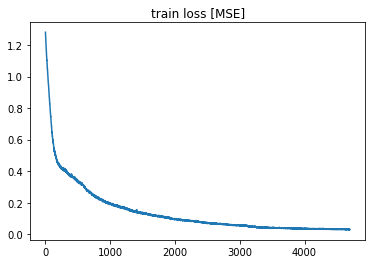

In [51]:
plt.title('train loss [MSE]')
sns.lineplot(x=range(len(losses)), y=losses)
plt.show()

In [ ]:
model.eval()

latents_xy = None
latents_c = None

for inputs, outputs in tqdm_nb(train_loader):
    inputs = inputs.to(device)
    y_encoder = model.encoder(inputs).to(device)
    y_decoder = model.decoder(y_encoder)
    
    xys = y_encoder.detach().cpu()
    labels = outputs.detach().cpu().reshape(-1, 1)
    if latents_xy == None:
        latents_xy = xys
        latents_c = labels
    else:
        latents_xy = torch.row_stack([latents_xy, xys])
        latents_c = torch.row_stack([latents_c, labels])

  0%|          | 0/938 [00:00<?, ?it/s]

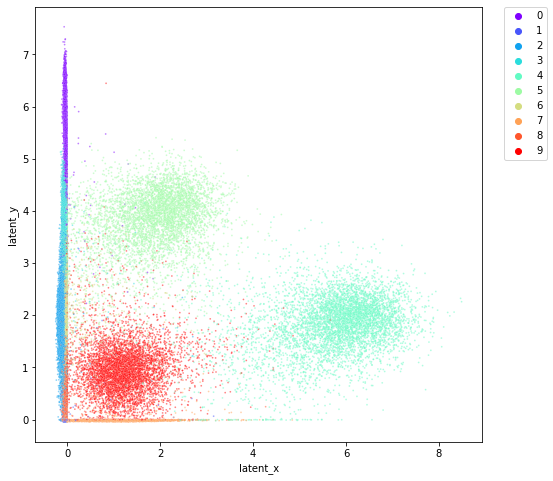

In [22]:
df = pd.DataFrame({'latent_x': latents_xy[:, 0], 'latent_y': latents_xy[:, 1], 'label': latents_c[:, 0]})
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df, x='latent_x', y='latent_y', hue='label', palette='rainbow', s=3, alpha=.5, legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

in fast, see 4 points: [[-7.0, 7.0], [7.0, 7.0], [-7.0, 0.0], [7.0, 0.0]]


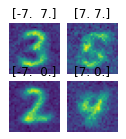

In [15]:
points = torch.tensor([(-7, 7), (7, 7), (-7, 0), (7, 0)]).float().to(device)
print('in fast, see 4 points:', points.tolist())
grid = imgrid(model.decoder(points).permute(0, 2, 3, 1).detach().cpu().numpy(), 2, 2)
for p, ax in zip(points, grid):
    ax.set_title(str(p.detach().cpu().numpy()))
plt.show()

In [16]:
show_sample(model, df, (-7, 7), (-7, 7), 25)
plt.show()

NameError: name 'show_sample' is not defined

In [50]:
inp = transform(valid_dataset.data.numpy().reshape(-1,28,28))
inp = inp.transpose(0,1)
inp = inp.reshape(-1,1,28,28).to(device)
z = model.encoder(inp)
z = z.detach().cpu().numpy()
y = valid_dataset.targets.numpy()

In [51]:
from sklearn.manifold import TSNE
import numpy as np
tsne = TSNE(n_components=2, verbose=1, n_iter=300, perplexity=5)
tsne_v = tsne.fit_transform(z[:6000])

ModuleNotFoundError: No module named 'sklearn'